# Basic Square/Cube Examples

In the following we will register two little squares/cubes to get familiar with the usage of torchreg.

In [1]:
import sys
sys.path.append('..')
import torch
import matplotlib.pyplot as plt
from torchreg import AffineRegistration

Creating squares

In [2]:
# Non-centered 3² square in 7² tensor
moving = torch.zeros(7, 7)
moving[1:4, 2:5] = 1
# Centered 3² square in 7² tensor
static = torch.zeros(7, 7)
static[2:5, 2:5] = 1

Plot before registration

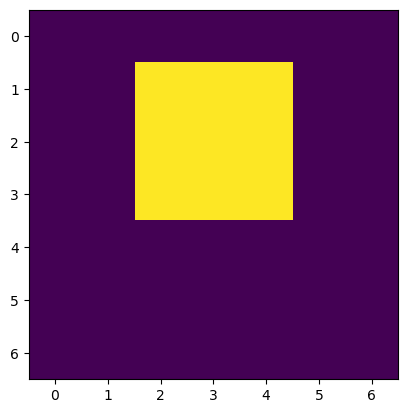

In [3]:
plt.imshow(moving);

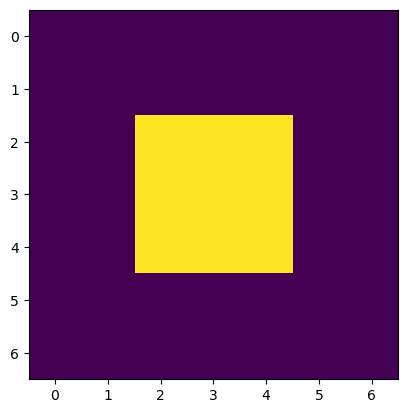

In [4]:
plt.imshow(static);

Initialize AffineRegistration with is_3d=False since we have 2D images.

Change scales from default (4, 2) to (1,) since downscaling would not make sense for 7x7 pixel resolution.

In [5]:
reg = AffineRegistration(is_3d=False, scales=(1,), learning_rate=1e-1)

Run registration with two dimensions added (via `[None, None]`)...

(...since it is torch convention for images to have **batch + channel** dimension prior to spatial dimensions x + y (+ z))

In [6]:
moved = reg(moving[None, None], static[None, None])
moved = moved[0, 0]

Shape: [1, 1, 7, 7]; Dissimiliarity: 1.1252674817332012e-13: 100%|██████████| 500/500 [00:00<00:00, 1205.78it/s]


Runs fast and dissimilarity approaches 0 ✔️

Let's look at the moved image!

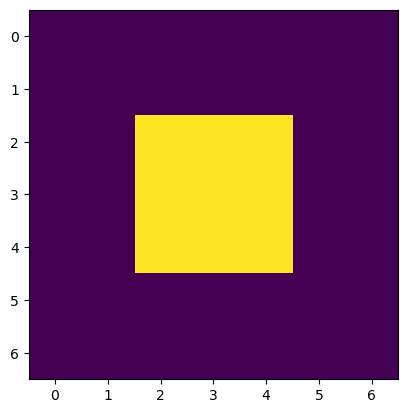

In [7]:
plt.imshow(moved);

Nice, the formally non-centered square (see moving-plot before registration) is now aligned to the static (see static-plot before registration) and therefore centered!

Next, extract the affine and the four parameters which were optimized in the background.

In [8]:
affine = reg.get_affine()
translation = reg._parameters[0]
rotation = reg._parameters[1]
zoom = reg._parameters[2]
shear = reg._parameters[3]

In [9]:
print(affine)

tensor([[[ 1.0000e+00,  4.2938e-08,  3.4270e-08],
         [-4.6447e-08,  1.0000e+00, -3.3333e-01]]])


In [10]:
print(translation, rotation, zoom, shear)

Parameter containing:
tensor([[ 3.4270e-08, -3.3333e-01]], requires_grad=True) Parameter containing:
tensor([[[ 1.0000e+00,  4.2938e-08],
         [-4.6447e-08,  1.0000e+00]]], requires_grad=True) Parameter containing:
tensor([[1.0000, 1.0000]], requires_grad=True) Parameter containing:
tensor([[0., 0.]])


As expected (we are aligning two identical squares which are shifted in one dimension), all parameter values except of one are near 0 or 1.

The "one value" `-3.3333e-01` is in the `translation` parameter as expected ✔️

## Important side note!!!

Unexpectedly, the `-3.3333e-01` value is in the **second** dimension of `translation` despite the misalignment being in the **first** dimension (`moving[1:4, 2:5] = 1` vs `static[2:5, 2:5] = 1`. That's because of the [torch convention of coordinate grids](https://discuss.pytorch.org/t/surprising-convention-for-grid-sample-coordinates/79997).

This convention results in:
- 2D: **X and Y coordinate are in the order `[Y, X]`**
- 3D: **X, Y and Z coordinate are in the order `[Z, Y, X]`**

A **workaround** if you don't like that is to flip the dimensions of the registrations input tensors via `.permute(1, 0)` (or `.permute(2, 1, 0)` in 3D):

In [11]:
reg = AffineRegistration(is_3d=False, scales=(1,), learning_rate=1e-2)
moved = reg(moving.permute(1, 0)[None, None], static.permute(1, 0)[None, None])
translation = reg._parameters[0]
print(translation)

Shape: [1, 1, 7, 7]; Dissimiliarity: 3.978223503509071e-06: 100%|██████████| 500/500 [00:00<00:00, 1186.11it/s] 

Parameter containing:
tensor([[-3.3333e-01, -1.8018e-06]], requires_grad=True)


## Cube registration (3D) without progress bar

In [12]:
# Non-centered 3³ cube in 7³ tensor
moving_cube = torch.zeros(7, 7, 7)
moving_cube[1:4, 2:5, 2:5] = 1
# Centered 3³ cube in 7³ tensor
static_cube = torch.zeros(7, 7, 7)
static_cube[2:5, 2:5, 2:5] = 1

reg = AffineRegistration(is_3d=True, scales=(1,),
                         verbose=False)  # verbose=False for hidden progress bar

moved_cube = reg(moving_cube[None, None], static_cube[None, None])
translation = reg._parameters[0]
rotation = reg._parameters[1]
zoom = reg._parameters[2]
shear = reg._parameters[3]
print(translation, rotation, zoom, shear)

Parameter containing:
tensor([[-4.7301e-08, -4.7325e-08, -3.2846e-01]], requires_grad=True) Parameter containing:
tensor([[[ 1.0000e+00, -1.7097e-08,  6.9077e-07],
         [-1.7084e-08,  1.0000e+00,  6.9076e-07],
         [ 1.5955e-09, -1.2442e-09,  1.0118e+00]]], requires_grad=True) Parameter containing:
tensor([[1.0000, 1.0000, 1.0118]], requires_grad=True) Parameter containing:
tensor([[0., 0., 0.]])


## Translation-only registration

In [13]:
reg = AffineRegistration(is_3d=False, scales=(1,),
                         with_rotation=False, with_zoom=False, with_shear=False)

moved = reg(moving[None, None], static[None, None])

translation = reg._parameters[0]
rotation = reg._parameters[1]
zoom = reg._parameters[2]
shear = reg._parameters[3]
print(translation, rotation, zoom, shear)

Shape: [1, 1, 7, 7]; Dissimiliarity: 2.7626772397537636e-11: 100%|██████████| 500/500 [00:00<00:00, 1899.94it/s]


Parameter containing:
tensor([[ 4.7112e-09, -3.3333e-01]], requires_grad=True) Parameter containing:
tensor([[[1., 0.],
         [0., 1.]]]) Parameter containing:
tensor([[1., 1.]]) Parameter containing:
tensor([[0., 0.]])


## Translation-only registration with initial parameter

In [14]:
reg = AffineRegistration(is_3d=False, scales=(1,), init_translation=torch.Tensor([[-3e-1, 0.]]),
                         with_rotation=False, with_zoom=False, with_shear=False)

moved = reg(moving[None, None], static[None, None])

translation = reg._parameters[0]
rotation = reg._parameters[1]
zoom = reg._parameters[2]
shear = reg._parameters[3]
print(translation, rotation, zoom, shear)

Shape: [1, 1, 7, 7]; Dissimiliarity: 8.85713030696067e-12: 100%|██████████| 500/500 [00:00<00:00, 1974.00it/s]  


Parameter containing:
tensor([[-2.2464e-07, -3.3333e-01]], requires_grad=True) Parameter containing:
tensor([[[1., 0.],
         [0., 1.]]]) Parameter containing:
tensor([[1., 1.]]) Parameter containing:
tensor([[0., 0.]])
